In [364]:
import os
import sys
import re
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import copy
import pickle

In [2]:
%load_ext autoreload
%autoreload 2

In [289]:
sys.path.append('../../statmechlib')
from statmechlib.read_write import read_vasp
from statmechlib.preprocessing import Trajectory

In [363]:
target_raw = '../data/target_raw'
target_proc = '../data/target_processed'
working = '../data/working'

datasets = ['bcc_npt_langevin_300K',
            'fcc_npt_langevin_300K',
            'vac_npt_langevin_2000K',
            'i110_npt_langevin_2000K',
            'i111_npt_langevin_2000K',
            'screw_111_npt_langevin_2000K',
            'bcc_npt_langevin_3700K',
            'liq_3700K',
            'liq_5000K']

datasets_0k = ['bcc_0k',
               'fcc_0k',
               'vac_0k',
               'i110_0k',
               'i111_0k',
               'screw_111_0k']

In [5]:
#with open(os.path.join(target_proc,  "datasets.pickle"), 'wb') as fo:
#    pickle.dump(datasets, fo)
#
#print(datasets)

In [6]:
trajdirs = [target_raw + '/' + dataset for dataset in datasets]
trajdirs_0k = [target_raw + '/' + dataset for dataset in datasets_0k]

In [92]:
trajectories = {}
for name, traj_path in zip(datasets, trajdirs):
    trajectories[name] = read_vasp(traj_path)

Reading ../data/target_raw/bcc_npt_langevin_300K/OUTCAR
Reading ../data/target_raw/bcc_npt_langevin_300K/POSCAR
Reading ../data/target_raw/bcc_npt_langevin_300K/CONTCAR
Reading ../data/target_raw/bcc_npt_langevin_300K/XDATCAR
Reading ../data/target_raw/bcc_npt_langevin_300K/OSZICAR
Reading ../data/target_raw/bcc_npt_langevin_300K/INCAR
Reading ../data/target_raw/fcc_npt_langevin_300K/OUTCAR
Reading ../data/target_raw/fcc_npt_langevin_300K/POSCAR
Reading ../data/target_raw/fcc_npt_langevin_300K/CONTCAR
Reading ../data/target_raw/fcc_npt_langevin_300K/XDATCAR
Reading ../data/target_raw/fcc_npt_langevin_300K/OSZICAR
Reading ../data/target_raw/fcc_npt_langevin_300K/INCAR
Reading ../data/target_raw/vac_npt_langevin_2000K/OUTCAR
Reading ../data/target_raw/vac_npt_langevin_2000K/POSCAR
Reading ../data/target_raw/vac_npt_langevin_2000K/CONTCAR
Reading ../data/target_raw/vac_npt_langevin_2000K/XDATCAR
Reading ../data/target_raw/vac_npt_langevin_2000K/OSZICAR
Reading ../data/target_raw/vac_npt_l

In [93]:
trajectories_0k = {}
for name, traj_path in zip(datasets_0k, trajdirs_0k):
    trajectories_0k[name] = read_vasp(traj_path)

Reading ../data/target_raw/bcc_0k/OUTCAR
Reading ../data/target_raw/bcc_0k/POSCAR
Reading ../data/target_raw/bcc_0k/CONTCAR
Reading ../data/target_raw/bcc_0k/XDATCAR
Reading ../data/target_raw/bcc_0k/OSZICAR
Reading ../data/target_raw/bcc_0k/INCAR
Reading ../data/target_raw/fcc_0k/OUTCAR
Reading ../data/target_raw/fcc_0k/POSCAR
Reading ../data/target_raw/fcc_0k/CONTCAR
Reading ../data/target_raw/fcc_0k/OSZICAR
Reading ../data/target_raw/fcc_0k/INCAR
Reading ../data/target_raw/vac_0k/OUTCAR
Reading ../data/target_raw/vac_0k/POSCAR
Reading ../data/target_raw/vac_0k/CONTCAR
Reading ../data/target_raw/vac_0k/OSZICAR
Reading ../data/target_raw/vac_0k/INCAR
Reading ../data/target_raw/i110_0k/OUTCAR
Reading ../data/target_raw/i110_0k/POSCAR
Reading ../data/target_raw/i110_0k/CONTCAR
Reading ../data/target_raw/i110_0k/XDATCAR
Reading ../data/target_raw/i110_0k/OSZICAR
Reading ../data/target_raw/i110_0k/INCAR
Reading ../data/target_raw/i111_0k/OUTCAR
Reading ../data/target_raw/i111_0k/POSCAR
Re

In [219]:
# Convert MD trajectory dicts to objects
trjs = {}
for k, trj in trajectories.items():
    trjs[k] = Trajectory(trj, inplace=False)

In [220]:
# Convert MD trajectory 0K configs to objects
trjs_0k = {}
for k, trj in trajectories_0k.items():
    trjs_0k[k] = Trajectory(trj, inplace=False)[-1]

In [222]:
# make screw trajectories large enough for cutoff of ~5.5A
trj_big_screw_0k = trjs_0k['screw_111_0k'].replicate(vec_a=1, vec_b=4, vec_c=1)
trj_big_screw = trjs['screw_111_npt_langevin_2000K'].replicate(vec_a=1, vec_b=4, vec_c=1)

In [223]:
# join 0 K configurations into a pseudo-trajectory
traj0k = copy.deepcopy(trjs_0k['bcc_0k'])

for k, trj in trjs_0k.items():
    print(k)
    if ('screw' not in k) and ('bcc' not in k):
        traj0k.append(trj)
    print(len(traj0k['box']))

traj0k.append(trj_big_screw_0k)

bcc_0k
1
fcc_0k
2
vac_0k
3
i110_0k
4
i111_0k
5
screw_111_0k
5


In [224]:
# Create an artificial configuration with large box and 0 energy
traj_inf = copy.deepcopy(trjs_0k['bcc_0k'])

In [225]:
def make_infinite_conf(trj):
    """
    Scales box size by 10 to separate all atoms beyond cutoff, and sets energies and forces to 0.
    
    Parameters
    ----------
    trj: Trajectory object (or dict)
         Trajectory to be rescaled
    
    Returns
    -------
    trj: Trajectory object (or dict)
         Rescaled trajectory
    """
    trj['box'][0] = trj['box'][0]*10
    trj['box0'] = trj['box0']*10
    trj['energy'][0] = 0.0
    trj['free_energy'][0] = 0.0
    trj['total_energy'][0] = 0.0
    trj['forces'][0] = np.zeros_like(trj['forces'][0])
    return trj

In [226]:
traj_inf = make_infinite_conf(traj_inf)

In [227]:
traj_inf['box0']

array([[127.48742045,   0.        ,   0.        ],
       [  0.        , 127.48742045,   0.        ],
       [  0.        ,   0.        , 127.48742045]])

In [253]:
traj0k['temp'] = [300.0 for _ in range(len(traj0k['temp']))]

In [242]:
traj0k.append(traj_inf)

In [230]:
trjs['screw_111_npt_langevin_2000K'] = trj_big_screw

In [245]:
trjs['relax'] = traj0k

5 [('W', [128])] 1496
5 [('W', [108])] 552
5 [('W', [127])] 1480
5 [('W', [129])] 1461
5 [('W', [129])] 1477
5 [('W', [135, 135, 135, 135]), ('W', [135, 135, 135, 135]), ('W', [135, 135, 135, 135]), ('W', [135, 135, 135, 135])] 1992
5 [('W', [128])] 1329
5 [('W', [113])] 1153
5 [('W', [113])] 1406
5 [('W', [128])] 7


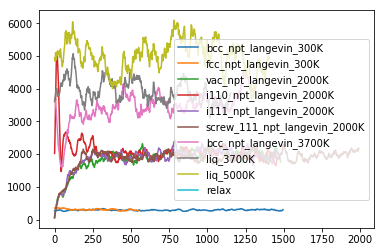

In [258]:
for key, trj in trjs.items():
    print(i, list(zip(trj['atom_name'], trj['atom_num'])), len(trj['temp']))
    plt.plot(trj['temp'], label=key)

plt.legend()
plt.show()

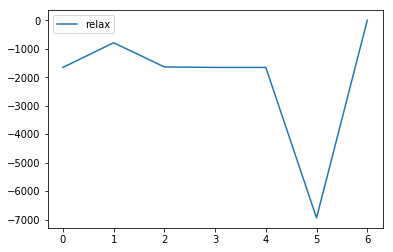

In [286]:
for key, trj in trjs.items():
    #print(i, list(zip(trj['atom_name'], trj['atom_num'])), len(trj['temp']))
    #if 'screw' not in key and 'relax' not in key:
    if 'relax' in key:
        plt.plot(trj['energy'], label=key)

plt.legend()
plt.show()

In [268]:
def get_msd(xyzs):
    """Return mean squared displacement (msd) for a given trajectory (traj)."""
    msd = []
    for rs in xyzs:
        msd.append(np.mean((rs - xyzs[0])**2))
    #msd = [0.0 for _ in range(len(xyzs))]
    return np.array(msd)

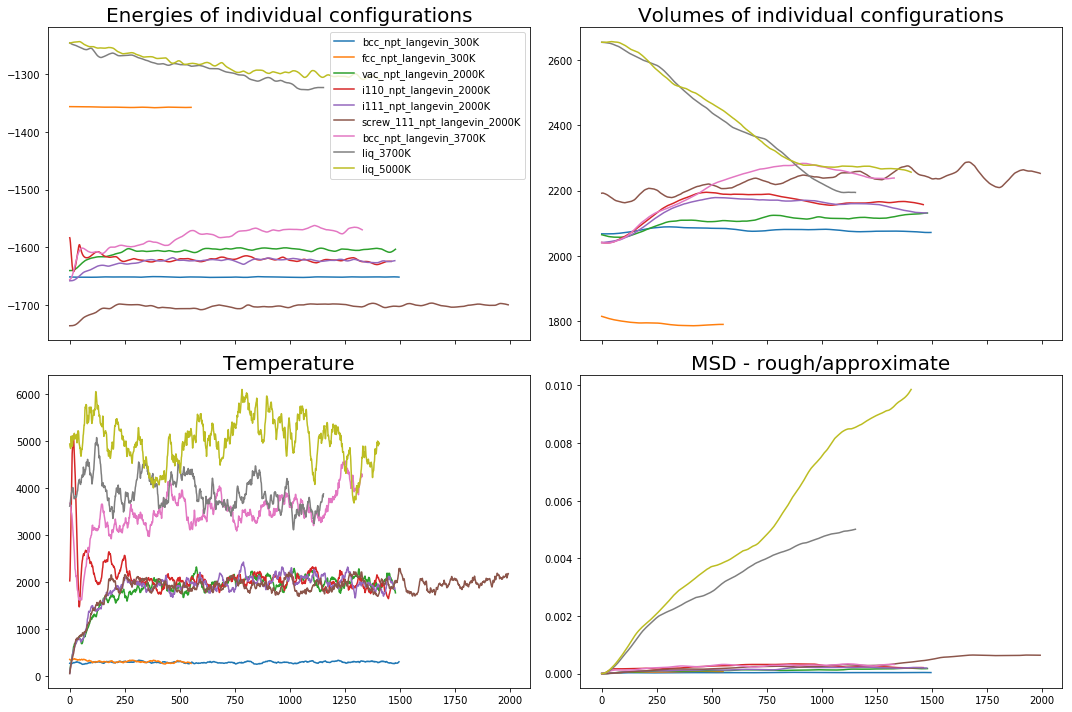

In [273]:
fig, axes = plt.subplots(2, 2, sharex='col', figsize=(15,10))

for key, traj in trjs.items():
    if 'relax' in key:
        continue

        
    #axes[0,0].plot([e/x.shape[0] for e, x in zip(traj['energy'], traj['xyz'])], label=dset)
    if 'screw' in key:
        axes[0,0].plot([e/4 for e, x in zip(traj['energy'], traj['xyz'])], label=key)
        axes[0,1].plot([np.linalg.det(b)/4 for b in traj['box']], label=key)
    else:
        axes[0,0].plot([e for e, x in zip(traj['energy'], traj['xyz'])], label=key)
        axes[0,1].plot([np.linalg.det(b) for b in traj['box']], label=key)


    axes[1,0].plot([t for t in traj['temp']], label=key)

    msd = get_msd(traj['xyz'])
    axes[1,1].plot(msd, label=key)

axes[0,0].legend()
axes[0,0].set_title('Energies of individual configurations', fontsize=20)
axes[0,1].set_title('Volumes of individual configurations', fontsize=20)       
axes[1,0].set_title('Temperature', fontsize=20)
axes[1,1].set_title('MSD - rough/approximate', fontsize=20)
fig.tight_layout()

In [274]:
[(k, len(v['energy'])) for k, v in trjs.items()]

[('bcc_npt_langevin_300K', 1496),
 ('fcc_npt_langevin_300K', 552),
 ('vac_npt_langevin_2000K', 1480),
 ('i110_npt_langevin_2000K', 1461),
 ('i111_npt_langevin_2000K', 1477),
 ('screw_111_npt_langevin_2000K', 1992),
 ('bcc_npt_langevin_3700K', 1329),
 ('liq_3700K', 1153),
 ('liq_5000K', 1406),
 ('relax', 7)]

In [281]:
cuts = {'bcc_npt_langevin_300K':100,
        'fcc_npt_langevin_300K':10,
        'vac_npt_langevin_2000K':300,
        'i110_npt_langevin_2000K':300,
        'i111_npt_langevin_2000K':300,
        'screw_111_npt_langevin_2000K':300,
        'bcc_npt_langevin_3700K':400,
        'liq_3700K':400,
        'liq_5000K':400,
        'relax':0}

In [282]:
trj_samples = {}
for key, traj in trjs.items():
    if 'relax' not in key:
        trj_samples[key] = traj[cuts[key]::2]
    else:
        trj_samples[key] = traj[cuts[key]:]

In [284]:
[(k, len(v['energy'])) for k, v in trj_samples.items()]

[('bcc_npt_langevin_300K', 698),
 ('fcc_npt_langevin_300K', 271),
 ('vac_npt_langevin_2000K', 590),
 ('i110_npt_langevin_2000K', 581),
 ('i111_npt_langevin_2000K', 589),
 ('screw_111_npt_langevin_2000K', 846),
 ('bcc_npt_langevin_3700K', 465),
 ('liq_3700K', 377),
 ('liq_5000K', 503),
 ('relax', 7)]

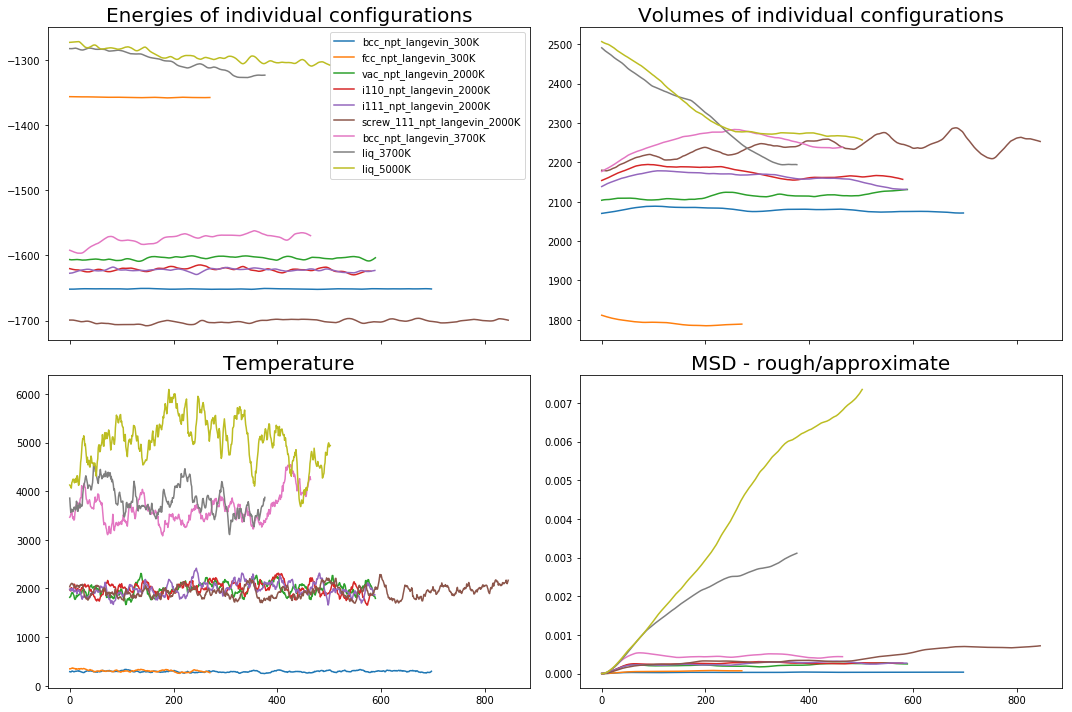

In [285]:
fig, axes = plt.subplots(2, 2, sharex='col', figsize=(15,10))

for key, traj in trj_samples.items():
    if 'relax' in key:
        continue

        
    #axes[0,0].plot([e/x.shape[0] for e, x in zip(traj['energy'], traj['xyz'])], label=dset)
    if 'screw' in key:
        axes[0,0].plot([e/4 for e, x in zip(traj['energy'], traj['xyz'])], label=key)
        axes[0,1].plot([np.linalg.det(b)/4 for b in traj['box']], label=key)
    else:
        axes[0,0].plot([e for e, x in zip(traj['energy'], traj['xyz'])], label=key)
        axes[0,1].plot([np.linalg.det(b) for b in traj['box']], label=key)


    axes[1,0].plot([t for t in traj['temp']], label=key)

    msd = get_msd(traj['xyz'])
    axes[1,1].plot(msd, label=key)

axes[0,0].legend()
axes[0,0].set_title('Energies of individual configurations', fontsize=20)
axes[0,1].set_title('Volumes of individual configurations', fontsize=20)       
axes[1,0].set_title('Temperature', fontsize=20)
axes[1,1].set_title('MSD - rough/approximate', fontsize=20)
fig.tight_layout()

In [287]:
weights = {k:1.0 for k in trj_samples}
weights['relax'] = 10.0

target_data = {}

for key, trj in trj_samples.items():
    
    print('dataset #', key)

    # target data
    target_dict = {'type':'trajectory', 'weight':weights[key]}
    target_dict['box'] = trj['box']
    target_dict['xyz'] = trj['xyz']
    target_dict['energy'] = trj['energy']
    target_dict['temp'] = trj['temp']

    # save inverse temperature data (if T=0, set beta=1/300)
    target_dict['beta'] = np.empty_like(target_dict['temp'])
    for i, temp in enumerate(target_dict['temp']):
        if temp == 0.0:
            target_dict['beta'][i] = 1.0/300.0
        else:
            target_dict['beta'][i] = 1.0/temp
            
    target_data[key] = target_dict

dataset # bcc_npt_langevin_300K
dataset # fcc_npt_langevin_300K
dataset # vac_npt_langevin_2000K
dataset # i110_npt_langevin_2000K
dataset # i111_npt_langevin_2000K
dataset # screw_111_npt_langevin_2000K
dataset # bcc_npt_langevin_3700K
dataset # liq_3700K
dataset # liq_5000K
dataset # relax


In [290]:
from statmechlib.preprocessing import pair_dist, get_stats_EAM

dataset # bcc_npt_langevin_300K
conf 0
conf 1
conf 2
conf 3
conf 4
conf 5
conf 6
conf 7
conf 8
conf 9
conf 10
conf 11
conf 12
conf 13
conf 14
conf 15
conf 16
conf 17
conf 18
conf 19
conf 20
conf 21
conf 22
conf 23
conf 24
conf 25
conf 26
conf 27
conf 28
conf 29
conf 30
conf 31
conf 32
conf 33
conf 34
conf 35
conf 36
conf 37
conf 38
conf 39
conf 40
conf 41
conf 42
conf 43
conf 44
conf 45
conf 46
conf 47
conf 48
conf 49
conf 50
conf 51
conf 52
conf 53
conf 54
conf 55
conf 56
conf 57
conf 58
conf 59
conf 60
conf 61
conf 62
conf 63
conf 64
conf 65
conf 66
conf 67
conf 68
conf 69
conf 70
conf 71
conf 72
conf 73
conf 74
conf 75
conf 76
conf 77
conf 78
conf 79
conf 80
conf 81
conf 82
conf 83
conf 84
conf 85
conf 86
conf 87
conf 88
conf 89
conf 90
conf 91
conf 92
conf 93
conf 94
conf 95
conf 96
conf 97
conf 98
conf 99
conf 100
conf 101
conf 102
conf 103
conf 104
conf 105
conf 106
conf 107
conf 108
conf 109
conf 110
conf 111
conf 112
conf 113
conf 114
conf 115
conf 116
conf 117
conf 118
conf 11

conf 230
conf 231
conf 232
conf 233
conf 234
conf 235
conf 236
conf 237
conf 238
conf 239
conf 240
conf 241
conf 242
conf 243
conf 244
conf 245
conf 246
conf 247
conf 248
conf 249
conf 250
conf 251
conf 252
conf 253
conf 254
conf 255
conf 256
conf 257
conf 258
conf 259
conf 260
conf 261
conf 262
conf 263
conf 264
conf 265
conf 266
conf 267
conf 268
conf 269
conf 270
dataset # vac_npt_langevin_2000K
conf 0
conf 1
conf 2
conf 3
conf 4
conf 5
conf 6
conf 7
conf 8
conf 9
conf 10
conf 11
conf 12
conf 13
conf 14
conf 15
conf 16
conf 17
conf 18
conf 19
conf 20
conf 21
conf 22
conf 23
conf 24
conf 25
conf 26
conf 27
conf 28
conf 29
conf 30
conf 31
conf 32
conf 33
conf 34
conf 35
conf 36
conf 37
conf 38
conf 39
conf 40
conf 41
conf 42
conf 43
conf 44
conf 45
conf 46
conf 47
conf 48
conf 49
conf 50
conf 51
conf 52
conf 53
conf 54
conf 55
conf 56
conf 57
conf 58
conf 59
conf 60
conf 61
conf 62
conf 63
conf 64
conf 65
conf 66
conf 67
conf 68
conf 69
conf 70
conf 71
conf 72
conf 73
conf 74
conf 75


conf 297
conf 298
conf 299
conf 300
conf 301
conf 302
conf 303
conf 304
conf 305
conf 306
conf 307
conf 308
conf 309
conf 310
conf 311
conf 312
conf 313
conf 314
conf 315
conf 316
conf 317
conf 318
conf 319
conf 320
conf 321
conf 322
conf 323
conf 324
conf 325
conf 326
conf 327
conf 328
conf 329
conf 330
conf 331
conf 332
conf 333
conf 334
conf 335
conf 336
conf 337
conf 338
conf 339
conf 340
conf 341
conf 342
conf 343
conf 344
conf 345
conf 346
conf 347
conf 348
conf 349
conf 350
conf 351
conf 352
conf 353
conf 354
conf 355
conf 356
conf 357
conf 358
conf 359
conf 360
conf 361
conf 362
conf 363
conf 364
conf 365
conf 366
conf 367
conf 368
conf 369
conf 370
conf 371
conf 372
conf 373
conf 374
conf 375
conf 376
conf 377
conf 378
conf 379
conf 380
conf 381
conf 382
conf 383
conf 384
conf 385
conf 386
conf 387
conf 388
conf 389
conf 390
conf 391
conf 392
conf 393
conf 394
conf 395
conf 396
conf 397
conf 398
conf 399
conf 400
conf 401
conf 402
conf 403
conf 404
conf 405
conf 406
conf 407
c

conf 48
conf 49
conf 50
conf 51
conf 52
conf 53
conf 54
conf 55
conf 56
conf 57
conf 58
conf 59
conf 60
conf 61
conf 62
conf 63
conf 64
conf 65
conf 66
conf 67
conf 68
conf 69
conf 70
conf 71
conf 72
conf 73
conf 74
conf 75
conf 76
conf 77
conf 78
conf 79
conf 80
conf 81
conf 82
conf 83
conf 84
conf 85
conf 86
conf 87
conf 88
conf 89
conf 90
conf 91
conf 92
conf 93
conf 94
conf 95
conf 96
conf 97
conf 98
conf 99
conf 100
conf 101
conf 102
conf 103
conf 104
conf 105
conf 106
conf 107
conf 108
conf 109
conf 110
conf 111
conf 112
conf 113
conf 114
conf 115
conf 116
conf 117
conf 118
conf 119
conf 120
conf 121
conf 122
conf 123
conf 124
conf 125
conf 126
conf 127
conf 128
conf 129
conf 130
conf 131
conf 132
conf 133
conf 134
conf 135
conf 136
conf 137
conf 138
conf 139
conf 140
conf 141
conf 142
conf 143
conf 144
conf 145
conf 146
conf 147
conf 148
conf 149
conf 150
conf 151
conf 152
conf 153
conf 154
conf 155
conf 156
conf 157
conf 158
conf 159
conf 160
conf 161
conf 162
conf 163
conf 164

conf 127
conf 128
conf 129
conf 130
conf 131
conf 132
conf 133
conf 134
conf 135
conf 136
conf 137
conf 138
conf 139
conf 140
conf 141
conf 142
conf 143
conf 144
conf 145
conf 146
conf 147
conf 148
conf 149
conf 150
conf 151
conf 152
conf 153
conf 154
conf 155
conf 156
conf 157
conf 158
conf 159
conf 160
conf 161
conf 162
conf 163
conf 164
conf 165
conf 166
conf 167
conf 168
conf 169
conf 170
conf 171
conf 172
conf 173
conf 174
conf 175
conf 176
conf 177
conf 178
conf 179
conf 180
conf 181
conf 182
conf 183
conf 184
conf 185
conf 186
conf 187
conf 188
conf 189
conf 190
conf 191
conf 192
conf 193
conf 194
conf 195
conf 196
conf 197
conf 198
conf 199
conf 200
conf 201
conf 202
conf 203
conf 204
conf 205
conf 206
conf 207
conf 208
conf 209
conf 210
conf 211
conf 212
conf 213
conf 214
conf 215
conf 216
conf 217
conf 218
conf 219
conf 220
conf 221
conf 222
conf 223
conf 224
conf 225
conf 226
conf 227
conf 228
conf 229
conf 230
conf 231
conf 232
conf 233
conf 234
conf 235
conf 236
conf 237
c

conf 216
conf 217
conf 218
conf 219
conf 220
conf 221
conf 222
conf 223
conf 224
conf 225
conf 226
conf 227
conf 228
conf 229
conf 230
conf 231
conf 232
conf 233
conf 234
conf 235
conf 236
conf 237
conf 238
conf 239
conf 240
conf 241
conf 242
conf 243
conf 244
conf 245
conf 246
conf 247
conf 248
conf 249
conf 250
conf 251
conf 252
conf 253
conf 254
conf 255
conf 256
conf 257
conf 258
conf 259
conf 260
conf 261
conf 262
conf 263
conf 264
conf 265
conf 266
conf 267
conf 268
conf 269
conf 270
conf 271
conf 272
conf 273
conf 274
conf 275
conf 276
conf 277
conf 278
conf 279
conf 280
conf 281
conf 282
conf 283
conf 284
conf 285
conf 286
conf 287
conf 288
conf 289
conf 290
conf 291
conf 292
conf 293
conf 294
conf 295
conf 296
conf 297
conf 298
conf 299
conf 300
conf 301
conf 302
conf 303
conf 304
conf 305
conf 306
conf 307
conf 308
conf 309
conf 310
conf 311
conf 312
conf 313
conf 314
conf 315
conf 316
conf 317
conf 318
conf 319
conf 320
conf 321
conf 322
conf 323
conf 324
conf 325
conf 326
c

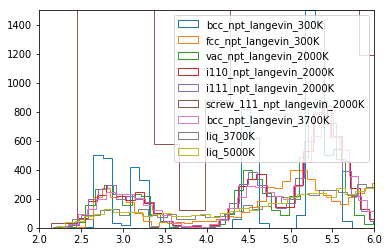

In [293]:
sc = [2.56, 2.73, 3.252, 3.804, 4.20, 4.77]

stats_data = {}

for key, trj in trj_samples.items():
    
    print('dataset #', key)

    # statistics data
    stats_dict = {'energy':[]}
    for ii, (xyz, box) in enumerate(zip(trj['xyz'], trj['box'])):
        print('conf', ii)
        
        rr, rx = pair_dist(xyz, box)

        a1, ar, a2, f1, fr, f2 = get_stats_EAM(rr, rx, sc)
        #print(xyz.shape, box)
        #print('x', a1.shape, rr.shape, np.sum(np.abs(a1)))

        stats_dict['energy'].append(np.array([ar, a2, a1]))
        #stats_dict['forces'].append(np.array([fr, f2, f1]))
               # add dataset
            
        #print('conf:', len(traj['xyz']), box.max())
        # plot pair distances - 
        if ii == 10:
            plt.hist(rr.flatten(),100, alpha=1.0,label=key, histtype='step')
            plt.xlim(2,6)
            plt.ylim(0,1500)
            
    plt.legend()
    stats_data[key] = stats_dict

In [294]:
stats_data['relax']

{'energy': [array([[0.00000000e+00, 0.00000000e+00, 1.24977518e+02, 4.14893461e+02,
          7.02396603e+02, 1.20725766e+03],
         [0.00000000e+00, 0.00000000e+00, 1.16331592e+02, 1.41291636e+04,
          1.16064579e+05, 1.01290793e+06],
         [0.00000000e+00, 0.00000000e+00, 1.22026406e+02, 1.34481706e+03,
          3.85438272e+03, 1.13864926e+04]]),
  array([[4.45474784e-02, 2.67853315e+01, 2.16495066e+02, 5.21047975e+02,
          7.96240392e+02, 1.27830467e+03],
         [3.12625517e-12, 4.08617382e-01, 1.74389667e+03, 5.85112779e+04,
          3.19084386e+05, 2.11966018e+06],
         [1.83748172e-05, 6.64309244e+00, 4.33982535e+02, 2.51380548e+03,
          5.87035891e+03, 1.51302115e+04]]),
  array([[0.00000000e+00, 0.00000000e+00, 1.24693724e+02, 4.12031629e+02,
          6.96601041e+02, 1.19614131e+03],
         [0.00000000e+00, 0.00000000e+00, 1.18087693e+02, 1.40780594e+04,
          1.15018376e+05, 9.99937445e+05],
         [0.00000000e+00, 0.00000000e+00, 1.224405

In [343]:
from statmechlib.preprocessing import get_stats_EAM_pairdist

In [345]:
# Convert MD trajectory dicts to objects
trjs = {}
for k, trj in trajectories.items():
    trjs[k] = Trajectory(trj, inplace=False)

In [346]:
# join 0 K configurations into a pseudo-trajectory
traj0kx = copy.deepcopy(trjs_0k['bcc_0k'])

for k, trj in trjs_0k.items():
    print(k)
    if 'bcc' not in k:
        traj0kx.append(trj)
    print(traj0kx['box'][-1])

#traj0k.append(trj_big_screw_0k)

bcc_0k
[[12.748742  0.        0.      ]
 [ 0.       12.748742  0.      ]
 [ 0.        0.       12.748742]]
fcc_0k
[[10.85089164  0.          0.        ]
 [ 0.         10.85089164  0.        ]
 [ 0.          0.         10.85089164]]
vac_0k
[[12.73304597  0.          0.        ]
 [ 0.         12.73304597  0.        ]
 [ 0.          0.         12.73304597]]
i110_0k
[[12.6836  0.      0.    ]
 [ 0.     12.6836  0.    ]
 [ 0.      0.     12.6836]]
i111_0k
[[12.6836  0.      0.    ]
 [ 0.     12.6836  0.    ]
 [ 0.      0.     12.6836]]
screw_111_0k
[[39.07300206  0.          0.        ]
 [ 0.          2.76287847  0.        ]
 [19.53650103  1.38143923 20.30292746]]


In [347]:
traj0kx.append(traj_inf)

In [349]:
trjs['relax'] = traj0kx

In [350]:
trj_samples = {}
for key, traj in trjs.items():
    if 'relax' not in key:
        trj_samples[key] = traj[cuts[key]::2]
    else:
        trj_samples[key] = traj[cuts[key]:]

In [351]:
trj_small = copy.deepcopy(trj_samples)

In [352]:
#trj_small['relax'] = traj0kx

In [353]:
[(k, len(v['energy'])) for k, v in trj_small.items()]

[('bcc_npt_langevin_300K', 698),
 ('fcc_npt_langevin_300K', 271),
 ('vac_npt_langevin_2000K', 590),
 ('i110_npt_langevin_2000K', 581),
 ('i111_npt_langevin_2000K', 589),
 ('screw_111_npt_langevin_2000K', 846),
 ('bcc_npt_langevin_3700K', 465),
 ('liq_3700K', 377),
 ('liq_5000K', 503),
 ('relax', 7)]

dataset # screw_111_npt_langevin_2000K
conf 0
Replicating: 1 4 1
conf 1
Replicating: 1 4 1
conf 2
Replicating: 1 4 1
conf 3
Replicating: 1 4 1
conf 4
Replicating: 1 4 1
conf 5
Replicating: 1 4 1
conf 6
Replicating: 1 4 1
conf 7
Replicating: 1 4 1
conf 8
Replicating: 1 4 1
conf 9
Replicating: 1 4 1
conf 10
Replicating: 1 4 1
conf 11
Replicating: 1 4 1
conf 12
Replicating: 1 4 1
conf 13
Replicating: 1 4 1
conf 14
Replicating: 1 4 1
conf 15
Replicating: 1 4 1
conf 16
Replicating: 1 4 1
conf 17
Replicating: 1 4 1
conf 18
Replicating: 1 4 1
conf 19
Replicating: 1 4 1
conf 20
Replicating: 1 4 1
conf 21
Replicating: 1 4 1
conf 22
Replicating: 1 4 1
conf 23
Replicating: 1 4 1
conf 24
Replicating: 1 4 1
conf 25
Replicating: 1 4 1
conf 26
Replicating: 1 4 1
conf 27
Replicating: 1 4 1
conf 28
Replicating: 1 4 1
conf 29
Replicating: 1 4 1
conf 30
Replicating: 1 4 1
conf 31
Replicating: 1 4 1
conf 32
Replicating: 1 4 1
conf 33
Replicating: 1 4 1
conf 34
Replicating: 1 4 1
conf 35
Replicating: 1 4 1

conf 296
Replicating: 1 4 1
conf 297
Replicating: 1 4 1
conf 298
Replicating: 1 4 1
conf 299
Replicating: 1 4 1
conf 300
Replicating: 1 4 1
conf 301
Replicating: 1 4 1
conf 302
Replicating: 1 4 1
conf 303
Replicating: 1 4 1
conf 304
Replicating: 1 4 1
conf 305
Replicating: 1 4 1
conf 306
Replicating: 1 4 1
conf 307
Replicating: 1 4 1
conf 308
Replicating: 1 4 1
conf 309
Replicating: 1 4 1
conf 310
Replicating: 1 4 1
conf 311
Replicating: 1 4 1
conf 312
Replicating: 1 4 1
conf 313
Replicating: 1 4 1
conf 314
Replicating: 1 4 1
conf 315
Replicating: 1 4 1
conf 316
Replicating: 1 4 1
conf 317
Replicating: 1 4 1
conf 318
Replicating: 1 4 1
conf 319
Replicating: 1 4 1
conf 320
Replicating: 1 4 1
conf 321
Replicating: 1 4 1
conf 322
Replicating: 1 4 1
conf 323
Replicating: 1 4 1
conf 324
Replicating: 1 4 1
conf 325
Replicating: 1 4 1
conf 326
Replicating: 1 4 1
conf 327
Replicating: 1 4 1
conf 328
Replicating: 1 4 1
conf 329
Replicating: 1 4 1
conf 330
Replicating: 1 4 1
conf 331
Replicating

conf 589
Replicating: 1 4 1
conf 590
Replicating: 1 4 1
conf 591
Replicating: 1 4 1
conf 592
Replicating: 1 4 1
conf 593
Replicating: 1 4 1
conf 594
Replicating: 1 4 1
conf 595
Replicating: 1 4 1
conf 596
Replicating: 1 4 1
conf 597
Replicating: 1 4 1
conf 598
Replicating: 1 4 1
conf 599
Replicating: 1 4 1
conf 600
Replicating: 1 4 1
conf 601
Replicating: 1 4 1
conf 602
Replicating: 1 4 1
conf 603
Replicating: 1 4 1
conf 604
Replicating: 1 4 1
conf 605
Replicating: 1 4 1
conf 606
Replicating: 1 4 1
conf 607
Replicating: 1 4 1
conf 608
Replicating: 1 4 1
conf 609
Replicating: 1 4 1
conf 610
Replicating: 1 4 1
conf 611
Replicating: 1 4 1
conf 612
Replicating: 1 4 1
conf 613
Replicating: 1 4 1
conf 614
Replicating: 1 4 1
conf 615
Replicating: 1 4 1
conf 616
Replicating: 1 4 1
conf 617
Replicating: 1 4 1
conf 618
Replicating: 1 4 1
conf 619
Replicating: 1 4 1
conf 620
Replicating: 1 4 1
conf 621
Replicating: 1 4 1
conf 622
Replicating: 1 4 1
conf 623
Replicating: 1 4 1
conf 624
Replicating

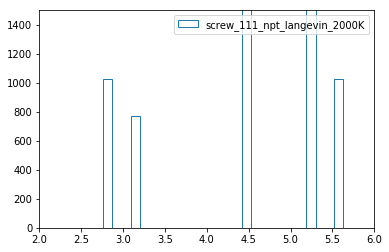

In [355]:
sc = [2.56, 2.73, 3.252, 3.804, 4.20, 4.77]

#stats_data_p = {}

for key, trj in trj_small.items():
    
    if 'screw' not in key:
        continue
    
    print('dataset #', key)

    # statistics data
    stats_dict = {'energy':[]}
    for ii, (xyz, box) in enumerate(zip(trj['xyz'], trj['box'])):
        print('conf', ii)
        
        #rr, rx = pair_dist(xyz, box)

        a1, ar, a2, f1, fr, f2 = get_stats_EAM_pairdist(xyz, box, sc=sc)
        #print(xyz.shape, box)
        #print('x', a1.shape, rr.shape, np.sum(np.abs(a1)))

        stats_dict['energy'].append(np.array([ar, a2, a1]))
        #stats_dict['forces'].append(np.array([fr, f2, f1]))
               # add dataset
            
        #print('conf:', len(traj['xyz']), box.max())
        # plot pair distances - 
        if ii == 10:
            plt.hist(rr.flatten(),100, alpha=1.0,label=key, histtype='step')
            plt.xlim(2,6)
            plt.ylim(0,1500)
            
    plt.legend()
    stats_data_p[key] = stats_dict

In [357]:
stats_data['screw_111_npt_langevin_2000K']['energy'][5], stats_data_p['screw_111_npt_langevin_2000K']['energy'][5]*4

(array([[3.39007697e+00, 3.88407268e+01, 5.82705728e+02, 1.79612731e+03,
         2.99481586e+03, 5.11904875e+03],
        [2.93389904e-04, 6.86145810e-02, 7.70497784e+02, 6.69806311e+04,
         5.14725557e+05, 4.37880493e+06],
        [1.15797530e-01, 3.98745004e+00, 6.34223271e+02, 5.98752159e+03,
         1.66300776e+04, 4.85604127e+04]]),
 array([[3.39007697e+00, 3.88407268e+01, 5.82705728e+02, 1.79612731e+03,
         2.99481586e+03, 5.11904875e+03],
        [2.93389904e-04, 6.86145810e-02, 7.70497784e+02, 6.69806311e+04,
         5.14725557e+05, 4.37880493e+06],
        [1.15797530e-01, 3.98745004e+00, 6.34223271e+02, 5.98752159e+03,
         1.66300776e+04, 4.85604127e+04]]))

In [358]:
trj_samples['screw_111_npt_langevin_2000K']['box'][1], trj_small['screw_111_npt_langevin_2000K']['box'][1]

(array([[ 3.9131845e+01,  7.5912500e-01, -2.0181400e-01],
        [-2.0258000e-02,  2.7236340e+00, -2.1052000e-02],
        [ 1.9571789e+01,  1.3839340e+00,  2.0339600e+01]]),
 array([[ 3.9131845e+01,  7.5912500e-01, -2.0181400e-01],
        [-2.0258000e-02,  2.7236340e+00, -2.1052000e-02],
        [ 1.9571789e+01,  1.3839340e+00,  2.0339600e+01]]))

In [359]:
weights = {k:1.0 for k in trj_samples}
weights['relax'] = 10.0

target_data_p = {}

for key, trj in trj_small.items():
    
    print('dataset #', key)

    # target data
    target_dict = {'type':'trajectory', 'weight':weights[key]}
    target_dict['box'] = trj['box']
    target_dict['xyz'] = trj['xyz']
    target_dict['energy'] = trj['energy']
    target_dict['temp'] = trj['temp']

    # save inverse temperature data (if T=0, set beta=1/300)
    target_dict['beta'] = np.empty_like(target_dict['temp'])
    for i, temp in enumerate(target_dict['temp']):
        if temp == 0.0:
            target_dict['beta'][i] = 1.0/300.0
        else:
            target_dict['beta'][i] = 1.0/temp
            
    target_data_p[key] = target_dict

dataset # bcc_npt_langevin_300K
dataset # fcc_npt_langevin_300K
dataset # vac_npt_langevin_2000K
dataset # i110_npt_langevin_2000K
dataset # i111_npt_langevin_2000K
dataset # screw_111_npt_langevin_2000K
dataset # bcc_npt_langevin_3700K
dataset # liq_3700K
dataset # liq_5000K
dataset # relax


In [377]:
stats_data['screw_111_npt_langevin_2000K']['energy'][5], stats_data_p['screw_111_npt_langevin_2000K']['energy'][5]*4

(array([[3.39007697e+00, 3.88407268e+01, 5.82705728e+02, 1.79612731e+03,
         2.99481586e+03, 5.11904875e+03],
        [2.93389904e-04, 6.86145810e-02, 7.70497784e+02, 6.69806311e+04,
         5.14725557e+05, 4.37880493e+06],
        [1.15797530e-01, 3.98745004e+00, 6.34223271e+02, 5.98752159e+03,
         1.66300776e+04, 4.85604127e+04]]),
 array([[3.39007697e+00, 3.88407268e+01, 5.82705728e+02, 1.79612731e+03,
         2.99481586e+03, 5.11904875e+03],
        [2.93389904e-04, 6.86145810e-02, 7.70497784e+02, 6.69806311e+04,
         5.14725557e+05, 4.37880493e+06],
        [1.15797530e-01, 3.98745004e+00, 6.34223271e+02, 5.98752159e+03,
         1.66300776e+04, 4.85604127e+04]]))

In [366]:
with open(os.path.join(working, "target_all.pickle"), 'wb') as fo:
    pickle.dump(target_data_p, fo)
    
with open(os.path.join(working, "stats_all.pickle"), 'wb') as fo:
    pickle.dump(stats_data_p, fo)

In [376]:
with open(os.path.join(working, "target_big.pickle"), 'wb') as fo:
    pickle.dump(target_data, fo)
    
with open(os.path.join(working, "stats_big.pickle"), 'wb') as fo:
    pickle.dump(stats_data, fo)

In [367]:
# load target data
with open(os.path.join(working, 'target_all'+'.pickle'), 'rb') as fi:
    targ_dict = pickle.load(fi)

# load stats data
with open(os.path.join(working, 'stats_all'+'.pickle'), 'rb') as fi:
    stats_dict = pickle.load(fi)

In [375]:
targ_dict.keys(), target_data_p.keys()

(dict_keys(['bcc_npt_langevin_300K', 'fcc_npt_langevin_300K', 'vac_npt_langevin_2000K', 'i110_npt_langevin_2000K', 'i111_npt_langevin_2000K', 'screw_111_npt_langevin_2000K', 'bcc_npt_langevin_3700K', 'liq_3700K', 'liq_5000K', 'relax']),
 dict_keys(['bcc_npt_langevin_300K', 'fcc_npt_langevin_300K', 'vac_npt_langevin_2000K', 'i110_npt_langevin_2000K', 'i111_npt_langevin_2000K', 'screw_111_npt_langevin_2000K', 'bcc_npt_langevin_3700K', 'liq_3700K', 'liq_5000K', 'relax']))

In [ ]:
# Create a combined 'trajectory' of 0K configurations
trj_0k = dict.fromkeys(trajectories_0k[0])

# Append the last relaxation configurations and corresponding energies
for i, trj in enumerate(trajectories_0k):
    for key in trj:
        #print('Start:', i, key, len(trj[key]), end=' ')
        if 'atom_name' in key:
            continue
        if type(trj[key]) == list:
            trj[key][:] = trj[key][min_conf[i]:]

In [38]:
for i, trj in enumerate(trajectories_0k):
    print(i, list(zip(trj['atom_name'], trj['atom_num'])), len(trj['energy']))
    plt.scatter(trj['energy'][-1], label=datasets_0k[i])
plt.legend()
plt.show()

0 [('W', 128)] 5


TypeError: scatter() missing 1 required positional argument: 'y'

In [ ]:
for i, params_uopt in enumerate(optimal_parameters[7:8]):
    opti_out, targ_out = udif_print(params_uopt, stats, target, utot_EAM)
    plt.title('Selected configurations at 0K')
    if i == len(optimal_parameters)-1:
        plt.plot([o for o in opti_out[-1][:-1]], 'x--', label='optimized')
        plt.plot(targ_out[-1][:-1], 'o', label='target', markersize=10)
    else:
        plt.plot([o for o in opti_out[-1][:-1]], 'x--')
        plt.plot(targ_out[-1][:-1], 'o', label='target', markersize=10)

plt.xticks([0, 1, 2, 3], ['BCC','vacancy','110','111'])
plt.ylabel('Energy [eV]')
plt.legend()

In [216]:
# Process trajectories - cut out the equilibration periods
#min_conf = [100, 150, 100, 0] # starting indices
min_conf = [0, 0, 0, 0] # starting indices

In [217]:
# cycle over trajectories and eliminate equilibration configurations in all
for i, trj in enumerate(trajectories):
    for key in trj:
        #print('Start:', i, key, len(trj[key]), end=' ')
        if 'atom_num' in key or 'atom_name' in key:
            continue
        if type(trj[key]) == list:
            trj[key][:] = trj[key][min_conf[i]:]
            
        #print('End:', i, key, len(trj[key]))

0 [('C', 32), ('N', 32), ('Ti', 96), ('O', 64), ('Al', 4), ('F', 12)] 619
1 [('C', 32), ('N', 32), ('Ti', 96), ('O', 64), ('Al', 4), ('F', 12)] 426
2 [('C', 32), ('N', 32), ('Ti', 96), ('F', 76), ('Al', 4)] 432
3 [('C', 32), ('N', 32), ('Ti', 96), ('F', 76), ('Al', 4)] 458


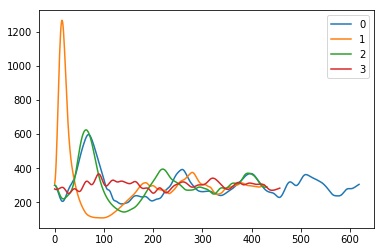

0 [('C', 32), ('N', 32), ('Ti', 96), ('O', 64), ('Al', 4), ('F', 12)] 619
1 [('C', 32), ('N', 32), ('Ti', 96), ('O', 64), ('Al', 4), ('F', 12)] 426
2 [('C', 32), ('N', 32), ('Ti', 96), ('F', 76), ('Al', 4)] 432
3 [('C', 32), ('N', 32), ('Ti', 96), ('F', 76), ('Al', 4)] 458


<function matplotlib.pyplot.legend(*args, **kwargs)>

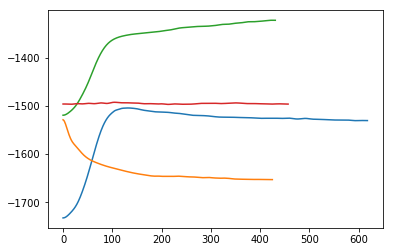

In [218]:
for i, trj in enumerate(trajectories):
    #for key in trj:
    print(i, list(zip(trj['atom_name'], trj['atom_num'])), len(trj['temp']))
    plt.plot(trj['temp'], label=i)

plt.legend()
plt.show()

for i, trj in enumerate(trajectories):
    #for key in trj:
    print(i, list(zip(trj['atom_name'], trj['atom_num'])), len(trj['energy']))
    plt.plot(trj['energy'], label=i)
plt.legend

In [219]:
trjs = []
for trj in trajectories:
    trj['ensemble'] = 'npt'
    trjs.append(Trajectory(trj, inplace=False))

In [220]:
trj_f = trjs[3]

In [221]:
#trj_f.append(trjs[2])

0 [('C', 32), ('N', 32), ('Ti', 96), ('O', 64), ('Al', 4), ('F', 12)] 519
1 [('C', 32), ('N', 32), ('Ti', 96), ('F', 76), ('Al', 4)] 458


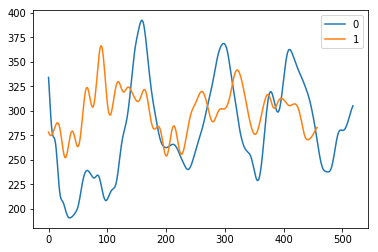

0 [('C', 32), ('N', 32), ('Ti', 96), ('O', 64), ('Al', 4), ('F', 12)] 519
1 [('C', 32), ('N', 32), ('Ti', 96), ('F', 76), ('Al', 4)] 458


<function matplotlib.pyplot.legend(*args, **kwargs)>

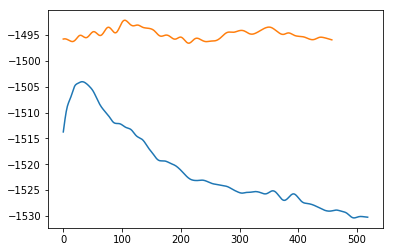

In [222]:
for i, trj in enumerate([trj_o, trj_f]):
    #for key in trj:
    print(i, list(zip(trj['atom_name'], trj['atom_num'])), len(trj['temp']))
    plt.plot(trj['temp'], label=i)

plt.legend()
plt.show()

for i, trj in enumerate([trj_o, trj_f]):
    #for key in trj:
    print(i, list(zip(trj['atom_name'], trj['atom_num'])), len(trj['energy']))
    plt.plot(trj['energy'], label=i)
plt.legend

In [223]:
#trj_o.to_xyz(os.path.join(target_raw, 'mx_o.xyz'))

In [228]:
trj_f.to_xyz(os.path.join(target_raw, 'mx_f.xyz'))
trjs[2].to_xyz(os.path.join(target_raw, 'mx_f0.xyz'))
trjs[0].to_xyz(os.path.join(target_raw, 'mx_o0.xyz'))

In [69]:
trj_f._trajectory.keys()

dict_keys(['box', 'xyz', 'atom_type', 'energy', 'forces', 'temp', 'free_energy', 'total_energy', 'atom_num', 'box0', 'xyz0', 'atom_type0', 'atom_name', 'ensemble'])

In [71]:
trj_f['box'][0]

array([[12.26800591,  0.        ,  0.        ],
       [-6.12871001, 10.63327471,  0.        ],
       [ 0.        ,  0.        , 22.39172064]])

In [72]:
trj_f_big = trj_f.replicate(vec_a=2, vec_b=2, vec_c=1)

atom_type 458 458


In [74]:
trj_f['box'][0], trj_f_big['box'][0]

(array([[12.26800591,  0.        ,  0.        ],
        [-6.12871001, 10.63327471,  0.        ],
        [ 0.        ,  0.        , 22.39172064]]),
 array([[ 24.53601182,   0.        ,   0.        ],
        [-12.25742002,  21.26654942,   0.        ],
        [  0.        ,   0.        ,  22.39172064]]))

In [75]:
trj_f_big.to_xyz(os.path.join(target_raw, 'mx_f_big.xyz'))

In [191]:
stats_big = [get_stats_Mie(xyz, box, atype, ms=[12, 6], rcut=8.0) for xyz, box, atype in zip(trj_f_big['xyz'][:2], trj_f_big['box'][:2], trj_f_big['atom_type'][:2])]

rcut: 8.0 (960, 960) (960, 960) (960, 960)
rcut: 8.0 (960, 960) (960, 960) (960, 960)


In [192]:
[s[0] for s in stats_big]

[{(0, 0): [0.03162699484710008, 0.6525214192650043],
  (0, 1): [0.10672188400541137, 1.6456098108578487],
  (0, 2): [0.08980721870694111, 8.130457894749211],
  (0, 3): [0.0008197648577815001, 0.6534306368314461],
  (0, 4): [1.0896124071947332e-06, 0.010061281492170431],
  (1, 1): [0.0003984254182350491, 0.305249168529528],
  (1, 2): [0.09797523164407955, 8.283863072227104],
  (1, 3): [0.0013876158843156756, 0.7949456979607498],
  (1, 4): [1.4066108079657566e-06, 0.010485025352389732],
  (2, 2): [0.003886293902995668, 2.977894095198382],
  (2, 3): [0.08397988232140166, 7.905704032368878],
  (2, 4): [3.551735270483283e-05, 0.06841585160076499],
  (3, 3): [0.007554726045737894, 2.556123720537764],
  (3, 4): [0.0803510575908502, 2.5779593104283736],
  (4, 4): [3.325807140913793e-08, 0.0005309305926080219]},
 {(0, 0): [0.031601778590005035, 0.6527506032628334],
  (0, 1): [0.10722600423540615, 1.647295504723056],
  (0, 2): [0.08997513233925168, 8.137276409146548],
  (0, 3): [0.00081864164366

In [187]:
stats = [get_stats_Mie(xyz, box, atype, ms=[12, 6], rcut=8.0) for xyz, box, atype in zip(trj_f['xyz'][:2], trj_f['box'][:2], trj_f['atom_type'][:2])]

Replicating: 2 2 1
rcut: 8.0 (240, 960) (240, 960) (240, 960)
Replicating: 2 2 1
rcut: 8.0 (240, 960) (240, 960) (240, 960)


In [188]:
[s[0] for s in stats]

[{(0, 0): [0.007906748711775052, 0.16313035481625124],
  (0, 1): [0.026680471001352783, 0.41140245271446196],
  (0, 2): [0.022451804676735285, 2.0326144736873033],
  (0, 3): [0.00020494121444537505, 0.16335765920786152],
  (0, 4): [2.724031017986833e-07, 0.002515320373042608],
  (1, 1): [9.960635455876223e-05, 0.07631229213238201],
  (1, 2): [0.024493807911019884, 2.0709657680567757],
  (1, 3): [0.0003469039710789188, 0.19873642449018736],
  (1, 4): [3.5165270199143894e-07, 0.0026212563380974326],
  (2, 2): [0.000971573475748917, 0.7444735237995957],
  (2, 3): [0.020994970580350405, 1.9764260080922191],
  (2, 4): [8.879338176208207e-06, 0.017103962900191248],
  (3, 3): [0.0018886815114344743, 0.639030930134441],
  (3, 4): [0.020087764397712562, 0.6444898276070936],
  (4, 4): [8.314517852284482e-09, 0.00013273264815200547]},
 {(0, 0): [0.007900444647501175, 0.1631876508157079],
  (0, 1): [0.026806501058851497, 0.4118238761807639],
  (0, 2): [0.022493783084812938, 2.034319102286638],
  (

In [204]:
stats[0][1][(0, 0)][-1][0]

array([-0.00022955, -0.00010835,  0.00035975])

In [208]:
stats_big[0][1][(0, 0)][-1][240]

array([-0.00022955, -0.00010835,  0.00035975])

1. Set charges based on Weiwei's charge info and past force fields
2. Take input parameters from the previous optimization
3. Create energy and force function for fitting (Start from EAM notebook)
4. Optimize

In [210]:
trj_o['box'][0], trj_f['box'][0]

(array([[12.06557696,  0.        ,  0.        ],
        [-6.05432642, 10.43313152,  0.        ],
        [ 0.        ,  0.        , 22.02162543]]),
 array([[12.26800591,  0.        ,  0.        ],
        [-6.12871001, 10.63327471,  0.        ],
        [ 0.        ,  0.        , 22.39172064]]))